In [61]:
%matplotlib inline

In [69]:
from fixtures import house_graph
from graph_tool.draw import graph_draw
from graph_tool.topology import kcore_decomposition
from graph_helpers import sort_pair
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
# from networkit import overview
# from graph_helpers import gt2nk

In [20]:
def get_kcore(g):
    return kcore_decomposition(g).a

In [18]:
original_g = house_graph()
# gnk = gt2nk(g)

In [16]:
"""
the graph:

       0
      / \
     /   \
    /     \
    1 --- 2
    |    /|
    |   / |
    | /   |
    |/    |
    3 --- 4 --- 5
"""   

'\nthe graph:\n\n       0\n      /      /       /         1 --- 2\n    |    /|\n    |   / |\n    | /   |\n    |/    |\n    3 --- 4 --- 5\n'

In [17]:
cand_edges = [(2, 5), (0, 5), (0, 4), (1, 4), (0, 3)]

In [78]:
g = original_g.copy()
# old_core = get_kcore(g)
pending_edges_g = nx.Graph()
active_edges_g = nx.Graph()

edge2meta_node = {}

pending_edges = set()
active_edges = set()

edge_dag = nx.DiGraph()
# meta_nodes = []
# meta_edges = []

for u, v in cand_edges:
    u, v = sort_pair([u, v])
    
    old_core = get_kcore(g)
    g.add_edge(u, v)
    new_core = get_kcore(g)
    affected_nodes = list((new_core != old_core).nonzero()[0])
    
    if affected_nodes:        
        print('adding ({}, {}) promotes {}'.format(u, v, affected_nodes))
        
        # get related pending edges
        # and create the meta node
        related_pending_edges = []
        for i in affected_nodes:
            if pending_edges_g.has_node(i):
                for j in pending_edges_g[i]:
                    if new_core[i] >= new_core[j]:
                        related_pending_edges.append((i, j))        
                
        related_pending_edges.append((u, v))
        # print('related pending edges', related_pending_edges)
        meta_node = tuple(set(sorted(map(sort_pair, related_pending_edges))))
        
        print('new meta node:', meta_node)
        
        # create the indexing
        for e in meta_node:
            edge2meta_node[e] = meta_node

        # get meta nodes dependencies            
        related_active_edges = []
        for i in affected_nodes:
            if active_edges_g.has_node(i):
                for j in active_edges_g[i]:
                    if new_core[i] <= new_core[j]:  # only peer or higher-core neighbors
                        related_active_edges.append((i, j))        
        
        related_active_edges = set(map(sort_pair, related_active_edges))
        # print('related active edges', related_active_edges)
        
        parent_meta_nodes = set()
        for e in related_active_edges:
            parent_meta_nodes.add(edge2meta_node[e])
        print('parent meta nodes', parent_meta_nodes)
                
        # update the edge_dag
        edge_dag.add_node(meta_node)
        for n in parent_meta_nodes:
            edge_dag.add_edge(n, meta_node)
        
        # these edges are not pending any more
        pending_edges_g.remove_edges_from(related_pending_edges)
        # these edges become active
        active_edges_g.add_edges_from(related_pending_edges)        
    else:
        print('adding ({}, {}) promotes nothing'.format(u, v))
        pending_edges_g.add_edge(u, v)
    print('-' * 10)

adding (2, 5) promotes [5]
new meta node: ((2, 5),)
parent meta nodes set()
----------
adding (0, 5) promotes [0, 1, 2, 3, 4, 5]
new meta node: ((0, 5),)
parent meta nodes {((2, 5),)}
----------
adding (0, 4) promotes nothing
----------
adding (1, 4) promotes nothing
----------
adding (0, 3) promotes [0, 1, 2, 3, 4]
new meta node: ((0, 3), (1, 4), (0, 4))
parent meta nodes set()
----------


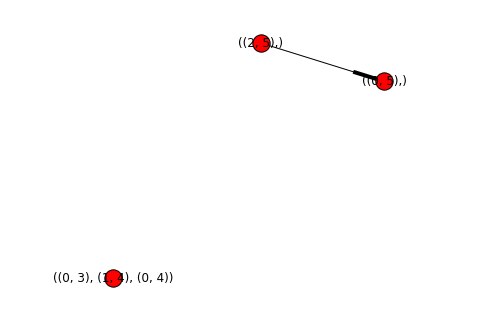

In [79]:
nx.draw(edge_dag, 
        pos=graphviz_layout(edge_dag),
        with_labels=True,
        prog='dot')
